## Unsupervised MNIST: part 1

### Linear variational autoencoder

##### a Pyro demo

Stephen Fleming, 20190204

for reference, see http://pyro.ai/examples/vae.html

In [1]:
USE_CUDA = True

__The generative model__

For a latent variable $z \in \mathbb{R}^q$, and observed data $x \in \mathbb{R}^d$ with $q < d$, and a scalar $\sigma$,

$$ z \sim \mathcal{N} (\mathbb{0}, \mathbb{1}) $$
$$ x | z \sim \mathcal{N} (W z + b, \sigma^2 \mathbb{1}) $$

Here $W$ is an arbitrary $d \times q$ matrix, and $b$ is a $d$-dimensional vector.  This sort of linear transformation ($W z + b$) can be parameterized using a PyTorch module called nn.Linear(), to make life easy.

Note that this model is not perfect... especially since the data have pixel intensities $\in \{0, 1 \}$.  You will see that the Pyro example on the website uses a Bernoulli distribution instead, and that their image reconstructions are binary.

![alt text](vae_model.png "Graphical model for a variational autoencoder")

__The variational posterior__

Given $x_i$, we would like a way to come up with $z_i$.  We could either memorize a new $z_i$ for each datapoint $i$, or we can _amortize_ our inference procedure by learning a mapping from $x$ to $z$.  We will do the latter.  Call that function $f(x)$.  Then our variational posterior for $p(z|x)$ is as follows:

$$ z_\mu, z_\sigma = f(x) $$
$$ z | x \sim \mathcal{N} (z_\mu, z_\sigma) $$

In [2]:
import pyro
from pyro.optim import Adamax
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO

pyro.enable_validation(True)

import torch
import torch.nn as nn
from torch.distributions import constraints
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Data loading

input shape: torch.Size([512, 1, 28, 28])
output shape: torch.Size([512])


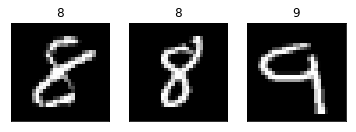

In [3]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = datasets.MNIST(root=root, train=True, transform=trans,
                               download=download)
    test_set = datasets.MNIST(root=root, train=False, transform=trans)

#     kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    kwargs = {'num_workers': 0, 'pin_memory': False}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

train_loader, test_loader = setup_data_loaders(batch_size=512, use_cuda=USE_CUDA)

# check out data loading to see what we get

for data in train_loader:
    print(f'input shape: {data[0].shape}')
    print(f'output shape: {data[1].shape}')
    plt.figure()
    for i in range(min(3, data[1].shape[0])):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[0][i, ...].numpy().squeeze(), cmap='gray')
        plt.title(data[1][i].item())
        plt.xticks([])
        plt.yticks([])
    plt.show()
    break

#### Define the encoder and decoder: use nn.Linear()

In [4]:
class Encoder(nn.Module):
    """A basic linear encoder.
    
    Encodes two parameters, 'loc' and 'scale', which are the 
    mean and standard deviation of a Gaussian in latent space.
    The 'scale' is made to be positive by applying torch.exp().
    
    """
    
    def __init__(self, d: int, q: int):
        super(Encoder, self).__init__()
        assert q < d, f"Latent space ({q}) must have smaller dimension that data ({d})."
        self.d = d
        self.q = q
        self.fc_mu = nn.Linear(d, q)
        self.fc_sigma = nn.Linear(d, q)
        
    def forward(self, x):
        return {'loc': self.fc_mu(x), 
                'scale': torch.exp(self.fc_sigma(x))}

In [5]:
class Decoder(nn.Module):
    """A basic fully-connected layer."""
    
    def __init__(self, q: int, d: int):
        super(Decoder, self).__init__()
        assert q < d, f"Latent space ({q}) must have smaller dimension that data ({d})."
        self.d = d
        self.q = q
        self.fc = nn.Linear(q, d)
        
    def forward(self, x):
        return self.fc(x)

#### Define the Pyro model and guide

In [6]:
class VAE(nn.Module):
    """Pyro model for a linear variational autoencoder.
    
    Attributes:
        encoder: pytorch nn.Module instance of an Encoder for p(z|x).
        decoder: pytorch nn.Module instance of a Decoder for p(x|z).
        use_cuda: True to use a GPU.
    
    """
    
    def __init__(self, 
                 encoder: Encoder, 
                 decoder: Decoder, 
                 use_cuda: bool = True):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.q = encoder.fc_mu.out_features
        self.d = encoder.fc_mu.in_features
        assert encoder.fc_mu.out_features == decoder.fc.in_features, \
            f"Latent space do not match for encoder ({encoder.fc_mu.out_features}) " \
            f"and decoder ({decoder.fc.in_features})"
        assert encoder.fc_mu.in_features == decoder.fc.out_features, \
            f"Data dimensions do not match for encoder ({encoder.fc_mu.in_features}) " \
            f"and decoder ({decoder.fc.out_features})"
        self.use_cuda = use_cuda and torch.cuda.is_available()
        self.device = 'cuda' if self.use_cuda else 'cpu'
        if self.use_cuda:
            self.cuda()  # puts the encoder and decoder params on GPU
    
    def model(self, x):
        """Model for data generation."""
        
        # Register the decoder module with pyro
        pyro.module("decoder", self.decoder)
        
        # A free parameter sigma
        sigma = pyro.param("sigma", 0.01*torch.ones(1).to(device=self.device))
        
        # Plate structure implies conditional independence of data points
        # in a batch
        with pyro.plate("data", size=x.shape[0]):
            
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.q)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.q)))
            
            # Draw z from the prior p(z)
            z = pyro.sample("z", dist.Normal(loc=z_loc, 
                                             scale=z_scale).to_event(1))
            
            # Draw x according to our model for p(x|z)
            pyro.sample("obs", dist.Normal(loc=self.decoder(z), 
                                           scale=sigma).to_event(1),
                        obs=x.view(x.shape[0], -1))
        
    def guide(self, x):
        """Guide: the inference network."""
        
        # Register the encoder module with pyro
        pyro.module("encoder", self.encoder)
        
        # Send the data through the encoder
        enc = self.encoder(x.view(x.shape[0], -1))
        
        # Inference of the latent embedding from the data:
        with pyro.plate("data", size=x.shape[0]):
            
            # Sample z from p(z|x)
            z = pyro.sample("z", dist.Normal(loc=enc['loc'],
                                             scale=enc['scale']).to_event(1))

In [7]:
# setting up the model

Q = 100  # dimensionality of our latent embedding

D = 28*28
assert Q < D, "The embedded dimension must be less than that of the data."

pyro.clear_param_store()

encoder = Encoder(D, Q)
decoder = Decoder(Q, D)

vae = VAE(encoder, decoder, use_cuda=USE_CUDA)

In [8]:
# setting up inference

optimizer = Adamax({"lr": 1.0e-3})

svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [9]:
# running inference

NUM_EPOCHS = 50
TEST_FREQUENCY = 5

train_loader, test_loader = setup_data_loaders(batch_size=512, use_cuda=USE_CUDA)

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 182056.3264
[epoch 000] average test loss: 75401.3584
[epoch 001]  average training loss: 61606.0218
[epoch 002]  average training loss: 42549.7276
[epoch 003]  average training loss: 32304.0869
[epoch 004]  average training loss: 25951.0180
[epoch 005]  average training loss: 21478.2573
[epoch 005] average test loss: 19189.5456
[epoch 006]  average training loss: 18108.7627
[epoch 007]  average training loss: 15480.3726
[epoch 008]  average training loss: 13374.1570
[epoch 009]  average training loss: 11643.1849
[epoch 010]  average training loss: 10182.5955
[epoch 010] average test loss: 9259.8036
[epoch 011]  average training loss: 8941.0316
[epoch 012]  average training loss: 7867.1729
[epoch 013]  average training loss: 6944.9093
[epoch 014]  average training loss: 6128.4167
[epoch 015]  average training loss: 5411.7607
[epoch 015] average test loss: 4900.5483
[epoch 016]  average training loss: 4776.1326
[epoch 017]  average training loss: 4211

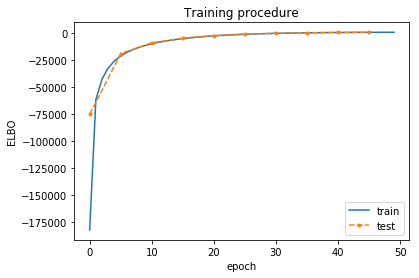

In [10]:
plt.plot(np.arange(0, len(train_elbo)), np.array(train_elbo))
plt.plot(np.arange(0, len(train_elbo), TEST_FREQUENCY), np.array(test_elbo), '.--')
plt.xlabel('epoch')
plt.ylabel('ELBO')
plt.title('Training procedure')
plt.legend(['train', 'test'])
plt.show()

#### Explore the latent embedding

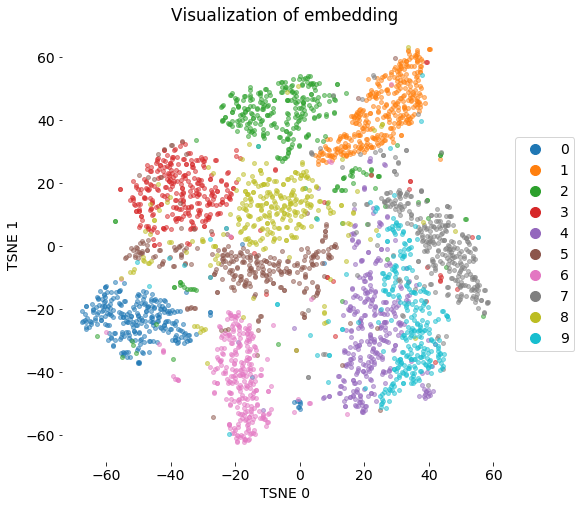

In [11]:
# examine the embedding...

# compute the embedding

z = np.empty([1, Q])
labels = np.empty(1)

for data in test_loader:
    if z.shape[0] >= 3000:
        break
    z = np.concatenate((z, vae.encoder(data[0].to(device=vae.device)
                                       .view(data[0].shape[0], -1))['loc']
                        .detach().cpu().numpy()))
    labels = np.concatenate((labels, data[1].numpy()))

z[np.isnan(z)] = 0
z[z > 1e100] = 1e100
    
# plot it

# and I know this sounds ridiculous but we have to do more
# dimensionality reduction to visualize our dimensionality reduction

from sklearn.manifold import TSNE

z_tsne = TSNE(n_components=2).fit_transform(z)

plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8, 8), frameon=False)
for k in np.unique(labels):
    plt.plot(z_tsne[labels==k, 0], 
             z_tsne[labels==k, 1], '.', ms=8, alpha=0.5)

lgnd = plt.legend(np.unique(labels).astype(int), 
                  loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(20)
    lgnd.legendHandles[i]._legmarker.set_alpha(1)

plt.xlabel('TSNE 0')
plt.ylabel('TSNE 1')
plt.title('Visualization of embedding')
plt.box(on=None)
plt.show()

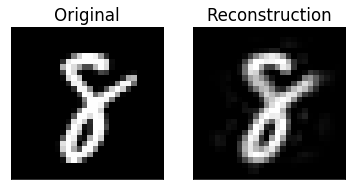

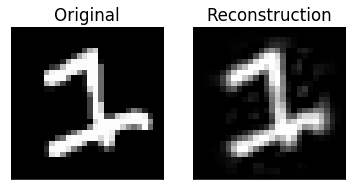

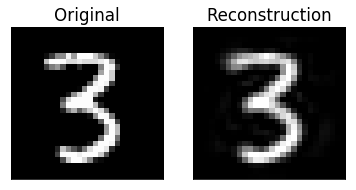

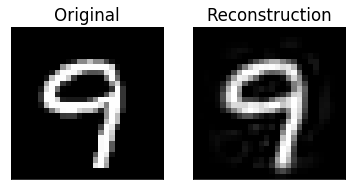

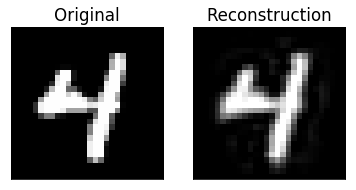

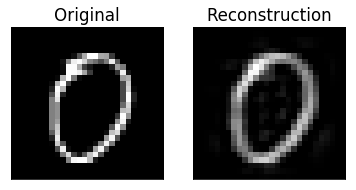

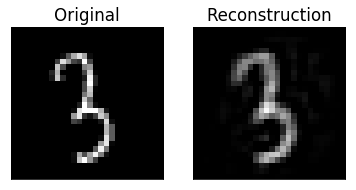

In [12]:
# image reconstruction

for d in range(data[0].shape[0]):
    plt.subplot(1, 2, 1)
    plt.imshow(data[0][d, ...].numpy().squeeze(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Original')
    
    plt.subplot(1, 2, 2)
    embedding = vae.encoder(data[0][d, ...].to(device=vae.device).view(1, -1))['loc']
    reconstruction = vae.decoder(embedding).detach().cpu().view((28, 28)).numpy()

    plt.imshow(reconstruction, cmap='gray',
               vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstruction')
    plt.show()
    if d > 5:
        break

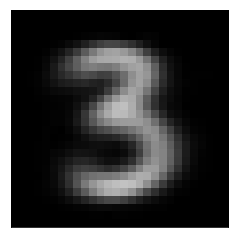

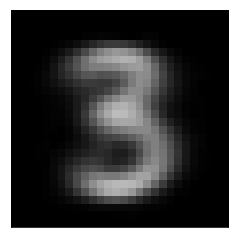

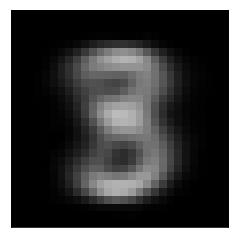

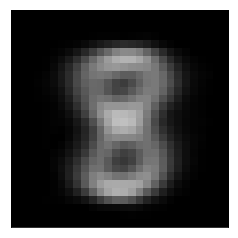

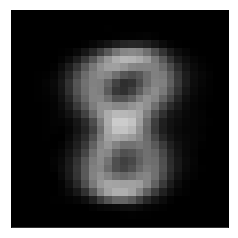

In [13]:
# draw me some numbers (this uses label information)
# interpolate between two digits

num1 = 3
num2 = 8

z1_mean = z[labels==num1].mean(axis=0)  # a sort of 'average digit' in latent space
z2_mean = z[labels==num2].mean(axis=0)

# for i in z1_mean.size:
z_interp = np.concatenate([np.expand_dims(np.linspace(z1_mean[i], z2_mean[i], 5), 0)
                           for i in range(z1_mean.size)]).transpose()
z_interp = torch.Tensor(z_interp).to(device=vae.device)

for i in range(z_interp.shape[0]):
    reconstruction = vae.decoder(z_interp[i, ...]).detach().cpu().view((28, 28)).numpy()
    
    plt.imshow(reconstruction, cmap='gray',
               vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.show()